In [1]:
import matplotlib.pyplot as plt

from celluloid import Camera
from IPython.display import Image

import random
#from random import random
import numpy as np

import math

import colorsys

from statistics import mean

import time as tm

In [2]:
GravityConst = 6.67E-11

In [3]:
class Object:
    
    #Праметры, общие для всех экземпляров класса Object, которые можно трогать пользователю
    Echo = False
    MaxDevAng = (np.pi / 180.0) * 1.0
    
    #Праметры, общие для всех экземпляров класса Object, которые вычисляются автоматически и недоступны для редактирования
    CosMaxDevAng = math.cos(MaxDevAng)
    
    
    def __init__(self, position = [0.0, 0.0, 0.0], velocity = [0.0, 0.0, 0.0], mass = 1.0, radius = 1.0):
        self.Position = np.array(position)
        self.Velocity = np.array(velocity)
        
        self.Mass = mass
        
        self.Radius = radius
        
        self.Trajectory = [[],[],[],[]]
        
        if self.Echo:
            print("Добавлен новый объект с параметрами:")
            print("\tПоложение в пространстве:", self.Position, "\tРасстояние до центра -", np.linalg.norm(self.Position))
            print("\tВектор скорости:         ", self.Velocity, "\tМодуль вектора -      ", np.linalg.norm(self.Velocity))
            print("\tРадиус: ", self.Radius)
            print("\tМасса:  ", self.Mass)
            print("")
            
    def CalcForce(self, other):
        ForceVec = np.array([0.0, 0.0, 0.0])
        
        DistanceVec = (self.Position - other.Position)
        DistanceMod = np.linalg.norm(DistanceVec)
        
        ForceVec = -GravityConst * (self.Mass * other.Mass * DistanceVec) / (DistanceMod * DistanceMod * DistanceMod)
        
        return ForceVec
    
    def CalcEnergy(self, other):
        Energy = 0.0
        
        DistanceMod = np.linalg.norm(self.Position - other.Position)
        
        Energy = -GravityConst * self.Mass * other.Mass / DistanceMod
        
        return Energy
    
    def CalcCollision(self, other):
        DistanceMod = np.linalg.norm(self.Position - other.Position)
        DistanceMax = self.Radius + other.Radius
        
        if DistanceMod <= DistanceMax:
            return True
        return False
    
    def UpdateTrajectory(self, time):
        LPN = len(self.Trajectory[0]) - 1
        
        if LPN <= 0:
            self.Trajectory[0].append(time)
            self.Trajectory[1].append(self.Position[0])
            self.Trajectory[2].append(self.Position[1])
            self.Trajectory[3].append(self.Position[2])
            return
        
        Point0 = np.array([self.Trajectory[1][LPN - 1], self.Trajectory[2][LPN - 1], self.Trajectory[3][LPN - 1]])
        Point1 = np.array([self.Trajectory[1][LPN - 0], self.Trajectory[2][LPN - 0], self.Trajectory[3][LPN - 0]])
        Point2 = self.Position
        
        Vector0 = Point1 - Point0
        Vector1 = Point2 - Point1
        
        Vector0 = Vector0 / np.linalg.norm(Vector0)
        Vector1 = Vector1 / np.linalg.norm(Vector1)
        
        CosDevAng = np.dot(Vector0, Vector1)
        
        if CosDevAng < self.CosMaxDevAng:
            self.Trajectory[0].append(time)
            self.Trajectory[1].append(self.Position[0])
            self.Trajectory[2].append(self.Position[1])
            self.Trajectory[3].append(self.Position[2])
         
    def ForceUpdateTrajectory(self, time):
        self.Trajectory[0].append(time)
        self.Trajectory[1].append(self.Position[0])
        self.Trajectory[2].append(self.Position[1])
        self.Trajectory[3].append(self.Position[2])
        
    def print(self):
        print("Объект:")
        print("\tПоложение в пространстве:", self.Position, "\tРасстояние до центра -", np.linalg.norm(self.Position))
        print("\tВектор скорости:         ", self.Velocity, "\tМодуль вектора -      ", np.linalg.norm(self.Velocity))
        print("\tРадиус: ", self.Radius)
        print("\tМасса:  ", self.Mass)
        print("")
    

In [4]:
class ObjectSystem:
    
    MaxEnergyDiviation = 1.0E-7
    TimeStepCorrection = 2.5000
    
    #------------------------------------------------------------------------------------------------------------------------
    
    def ColorRGB(self, i):
        s = 0.7
        b = 0.5
        h = (i * np.pi) - (int(i * np.pi))

        color = colorsys.hsv_to_rgb(h,s,b)
        
        return color
    
    def Low_Accuracy(self):
        self.MaxEnergyDiviation = 1.0E-4
        
    def High_Accuracy(self):
        self.MaxEnergyDiviation = 1.0E-8
        
    def Normal_Accuracy(self):
        self.MaxEnergyDiviation = 1.0E-7
    
    #------------------------------------------------------------------------------------------------------------------------
    
    def __init__(self):
        self.objects = []
        self.calcfac = []
        
        self.dts   = []
        self.Ts = []
        
        self.T  = 0.00
        self.dt = 0.001
    
    #------------------------------------------------------------------------------------------------------------------------
    
    def Add_Object(self, obj):
        self.objects.append(obj)
        self.calcfac.append(True)
        
        if(np.linalg.norm(obj.Velocity) != 0):
            self.dts.append( 1.0 / (np.linalg.norm(obj.Velocity)**(1.5)) )
        else:
            self.dts.append(self.dt)
        self.Ts.append(self.T)
        
    def Add_Object_parameters(self, position, velocity, mass, radius):
        t_obj = Object(position, velocity, mass, radius)
        
        self.Add_Object(t_obj)
        
    def Add_Object_period(self, period, mass, radius, coef = 0.707):
        t_obj = Object()
        
        FullMass = 0;
        WeigMass = np.array([0, 0, 0]);
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            WeigMass = WeigMass + obj.Mass * obj.Position
        
        CMassVec = WeigMass / FullMass
        
        PositionMod = abs(( 0.5 * coef * coef * GravityConst * FullMass * ( (period/np.pi)**2 ) )**(1.0/3.0))
        VelocityMod = coef * math.sqrt(GravityConst*2*FullMass / PositionMod)
        #VelocityMod = ( 2.0 * np.pi / period ) * PositionMod
        
        AngAzi = random.random() * 2.0 * np.pi
        AngVer = random.random() * 2.0 * np.pi
        RanDir1 = np.array([math.cos(AngVer)*math.cos(AngAzi), math.cos(AngVer)*math.sin(AngAzi), math.sin(AngVer)])
        
        t_obj.Position = CMassVec + RanDir1 * PositionMod
        
        AngAzi = random.random() * 2.0 * np.pi
        AngVer = random.random() * 2.0 * np.pi
        RanDir2 = np.array([math.cos(AngVer)*math.cos(AngAzi), math.cos(AngVer)*math.sin(AngAzi), math.sin(AngVer)])
        
        PerDir = np.cross(RanDir1, RanDir2)
        PerDir = PerDir / np.linalg.norm(PerDir)
        
        t_obj.Velocity = VelocityMod * PerDir
        
        t_obj.Mass = mass
        t_obj.Radius = radius
        
        self.Add_Object(t_obj)
        
    def Add_Object_orbit(self, orbit_rad, mass, radius, coef = 0.707):
        FullMass = 0
        
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            
        period = (np.pi / coef) * math.sqrt(2.0 * orbit_rad * orbit_rad * orbit_rad / (GravityConst * FullMass))
        
        self.Add_Object_period(period, mass, radius, coef)
        
    def Add_Object_velocity(self, VelocityMod, mass, radius, coef = 0.707):
        FullMass = 0
        
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            
        period = 4.0 * np.pi * GravityConst * FullMass / (VelocityMod**3.0)
        
        self.Add_Object_period(period, mass, radius, coef)
        
    def Add_new_mass_center(self, radius, power=1.0, position=[0.,0.,0.], velocity=[0.,0.,0.]):
        FullMass = 0
        
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            
        mass = FullMass * (10**power)
        
        t_obj = Object(position, velocity, mass, radius)
        self.Add_Object(t_obj)
        
    #------------------------------------------------------------------------------------------------------------------------
        
    def Add_Planet_orbit(self, orbit_rad, radius, coef = 0.707):
        FullMass = 0
        
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            
        RanNum1 = random.random() * 10.
        RanNum2 = random.random() * 2.0 + 4.0
        
        mass = RanNum1*(FullMass / (10**RanNum2))
        
        self.Add_Object_orbit(orbit_rad, mass, radius, coef)
        
    def Add_Star_orbit(self, orbit_rad, radius, coef = 0.707):
        FullMass = 0
        
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            
        self.Add_Object_orbit(orbit_rad, FullMass, radius, coef)
        
    def Add_Satellite(self, obj, radius, coef = 0.707):
        FullMass = 0;
        WeigMass = np.array([0, 0, 0])
        
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            WeigMass = WeigMass + obj.Mass * obj.Position
        
        CMassVec = WeigMass / FullMass
        
        ObjRad = np.linalg.norm(obj.Position - CMassVec)
        
        MaxSatRad = 0.1 * obj.Mass * ObjRad / FullMass
        #MinSatRad = obj.Radius * 2.0
        MinSatRad = 0
        
        if(MaxSatRad <= MinSatRad):
            print("Cant Create Satellite")
            return
        
        SatRad = random.random()*(MaxSatRad - MinSatRad) + MinSatRad
        
        RanNum1 = random.random() * 10.
        RanNum2 = random.random() * 5.0 + 3.0
        
        SatMass = RanNum1 * (obj.Mass / (10**RanNum2))
        
        AngAzi = random.random() * 2.0 * np.pi
        AngVer = random.random() * 2.0 * np.pi
        RanDir1 = np.array([math.cos(AngVer)*math.cos(AngAzi), math.cos(AngVer)*math.sin(AngAzi), math.sin(AngVer)])
        
        SatPosition = obj.Position + RanDir1 * SatRad
        
        AngAzi = random.random() * 2.0 * np.pi
        AngVer = random.random() * 2.0 * np.pi
        RanDir2 = np.array([math.cos(AngVer)*math.cos(AngAzi), math.cos(AngVer)*math.sin(AngAzi), math.sin(AngVer)])
        
        PerDir = np.cross(RanDir1, RanDir2)
        PerDir = PerDir / np.linalg.norm(PerDir)
        
        SatVelocityMod = coef * math.sqrt(GravityConst * obj.Mass / SatRad)
        
        SatVelocity = PerDir * SatVelocityMod
        
        t_obj = Object(SatPosition, SatVelocity, SatMass, radius)
        self.Add_Object(t_obj)
        
    def Add_Asteroid(self, position, velocity, mass, radius):
        self.Add_Object(position, velocity, mass, radius)
        
    #------------------------------------------------------------------------------------------------------------------------
    
    def CalcForces(self):
        forces = [np.array([0.0,0.0,0.0])] * len(self.objects)
        for i in range(len(self.objects)):
            for q in range(i + 1, len(self.objects)):
                IForce = self.objects[i].CalcForce(self.objects[q])
                forces[i] = forces[i] + IForce
                forces[q] = forces[q] - IForce
        return forces
    
    def CalcEnergy(self):
        energy = 0;
        for i in range(len(self.objects)):
            energy = energy + 0.5 * self.objects[i].Mass * (np.linalg.norm(self.objects[i].Velocity)**2)
            for q in range(i + 1, len(self.objects)):
                energy = energy - 6.67E-11 * self.objects[i].Mass * self.objects[q].Mass / np.linalg.norm(self.objects[i].Position - self.objects[q].Position)
        return energy
    
    def CalcImpulse(self):
        impulse = np.array([0,0,0])
        for obj in self.objects:
            impulse = impulse + obj.Mass * obj.Velocity
        return impulse;
        
    #------------------------------------------------------------------------------------------------------------------------
    
    def Iteration(self):
        Forces = self.CalcForces()
        
        self.T = self.T + self.dt
        
        for i in range(len(self.objects)):
            
            while self.T > self.Ts[i] + self.dts[i]:
                
                Energy1 = self.CalcEnergy()
                
                self.objects[i].Velocity = self.objects[i].Velocity + (Forces[i] / self.objects[i].Mass) * self.dts[i]
                self.objects[i].Position = self.objects[i].Position + self.objects[i].Velocity * self.dts[i] + 0.5 * (Forces[i] / self.objects[i].Mass) * self.dts[i] * self.dts[i]
                self.objects[i].UpdateTrajectory(self.T)
                self.Ts[i] = self.Ts[i] + self.dts[i]
                
                Energy2 = self.CalcEnergy()
                
                EnergyDiviation = 2.0 * abs((Energy1 - Energy2) / (Energy1 + Energy2))
                
                if EnergyDiviation > self.MaxEnergyDiviation:
                    self.dts[i] /= self.TimeStepCorrection
                else:
                    self.dts[i] *= self.TimeStepCorrection
            
        self.dt = min(self.dts)
        if self.dt == 0:
            print("Oh no , dt = 0.0")
            
            
    def IterateTime(self, Time):
        Time = self.T + Time
        
        while self.T <= Time:
            self.Iteration()
            
        for obj in self.objects:
            obj.ForceUpdateTrajectory(self.T)
    
    #------------------------------------------------------------------------------------------------------------------------
    
    def DraftIteration(self):
        Energy1 = self.CalcEnergy()
        
        
        Forces = self.CalcForces()
        
        for i in range(len(self.objects)):
            self.objects[i].Velocity = self.objects[i].Velocity + (Forces[i] / self.objects[i].Mass) * self.dt
            self.objects[i].Position = self.objects[i].Position + self.objects[i].Velocity * self.dt + 0.5 * (Forces[i] / self.objects[i].Mass) * self.dt * self.dt
            self.objects[i].UpdateTrajectory(self.T)
            self.T = self.T + self.dt
        
        
        Energy2 = self.CalcEnergy()
        
        EnergyDiviation = 2.0 * abs((Energy1 - Energy2) / (Energy1 + Energy2))
        #print("Energy Diviation:", EnergyDiviation)
        if EnergyDiviation > self.MaxEnergyDiviation:
            self.dt /= self.TimeStepCorrection
        else:
            self.dt *= self.TimeStepCorrection
            
    def DraftIterateTime(self, Time):
        Time = self.T + Time
        
        while self.T <= Time:
            self.DraftIteration()
            
        for obj in self.objects:
            obj.ForceUpdateTrajectory(self.T)
        
    #------------------------------------------------------------------------------------------------------------------------
    
    def SimpleIteration(self, dt):
        Forces = self.CalcForces()
        
        for i in range(len(self.objects)):
            self.objects[i].Velocity = self.objects[i].Velocity + (Forces[i] / self.objects[i].Mass) * dt
            self.objects[i].Position = self.objects[i].Position + self.objects[i].Velocity * dt + 0.5 * (Forces[i] / self.objects[i].Mass) * dt * dt
            self.objects[i].UpdateTrajectory(self.T)
            self.T = self.T + dt
            
    def SimpleIterateTime(self, Time, dt):
        Time = self.T + Time
        
        while self.T <= Time:
            self.SimpleIteration(dt)
            
        for obj in self.objects:
            obj.ForceUpdateTrajectory(self.T)
            
    #------------------------------------------------------------------------------------------------------------------------    
    
    def print_objects(self):
        for obj in self.objects:
            obj.print()
    
    #------------------------------------------------------------------------------------------------------------------------
    
    def calc_draw_limits(self):
        print("Calculating")
        FullMass = 0;
        WeigMass = np.array([0, 0, 0])
        
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            WeigMass = WeigMass + obj.Mass * obj.Position
        
        
        SystemCenter = WeigMass / FullMass
        
        XModAv = []
        YModAv = []
        ZModAv = []
        
        for i in range(len(self.objects)):
            obj = self.objects[i]
            
            if len(obj.Trajectory[0]) <= 0:
                break
            
            X = obj.Trajectory[1]
            Y = obj.Trajectory[2]
            Z = obj.Trajectory[3]
            
            XModAv.append( max( abs(max(X) - SystemCenter[0]) , abs(min(X) - SystemCenter[0]) ) )
            YModAv.append( max( abs(max(Y) - SystemCenter[1]) , abs(min(Y) - SystemCenter[1]) ) )
            ZModAv.append( max( abs(max(Z) - SystemCenter[2]) , abs(min(Z) - SystemCenter[2]) ) )
            
        AvX = mean(XModAv) * 2.0
        AvY = mean(YModAv) * 2.0
        AvZ = mean(ZModAv) * 2.0
            
        Av = max(AvX, AvY, AvZ)
        
        self.DrawLimits = [[0.,0.],[0.,0.],[0.,0.]]
        
        self.DrawLimits[0] = [SystemCenter[0] - Av - 1, SystemCenter[0] + Av + 1]
        self.DrawLimits[1] = [SystemCenter[1] - Av - 1, SystemCenter[1] + Av + 1]
        self.DrawLimits[2] = [SystemCenter[2] - Av - 1, SystemCenter[2] + Av + 1]
    
    def draw(self):
        FullMass = 0;
        WeigMass = np.array([0, 0, 0])
        
        for obj in self.objects:
            FullMass = FullMass + obj.Mass
            WeigMass = WeigMass + obj.Mass * obj.Position
        
        
        SystemCenter = WeigMass / FullMass
        
        XModAv = []
        YModAv = []
        ZModAv = []
        
        
        fig = plt.figure(figsize=(10, 10), dpi=100)
        axs = fig.add_subplot(111, projection='3d')
        axs.set_title("Траектории Тел Системы")
        
        for i in range(len(self.objects)):
            obj = self.objects[i]
            
            if len(obj.Trajectory[0]) <= 0:
                break;
            
            X = obj.Trajectory[1]
            Y = obj.Trajectory[2]
            Z = obj.Trajectory[3]
            
            XModAv.append( max( abs(max(X) - SystemCenter[0]) , abs(min(X) - SystemCenter[0]) ) )
            YModAv.append( max( abs(max(Y) - SystemCenter[1]) , abs(min(Y) - SystemCenter[1]) ) )
            ZModAv.append( max( abs(max(Z) - SystemCenter[2]) , abs(min(Z) - SystemCenter[2]) ) )
            
            color = self.ColorRGB(i)
            
            Size = len(X)
            X1 = [X[Size - 1], X[Size - 2]]
            Y1 = [Y[Size - 1], Y[Size - 2]]
            Z1 = [Z[Size - 1], Z[Size - 2]]
            
            axs.plot3D(X, Y, Z, "--", color=color, linewidth=1.5)
            axs.scatter(X1, Y1, Z1, s=20, color=color)
            
            
        AvX = mean(XModAv) * 2.0
        AvY = mean(YModAv) * 2.0
        AvZ = mean(ZModAv) * 2.0
            
        Av = max(AvX, AvY, AvZ)
            
        axs.axes.set_xlim3d( SystemCenter[0] - Av - 1 , SystemCenter[0] + Av + 1 )
        axs.axes.set_ylim3d( SystemCenter[1] - Av - 1 , SystemCenter[1] + Av + 1 )
        axs.axes.set_zlim3d( SystemCenter[2] - Av - 1 , SystemCenter[2] + Av + 1 )
    
    def animate(self, time1, time2, frames, fps, trace_time = 1.0E+3):
        
        fig = plt.figure(figsize=(10, 10), dpi=100)
        axs = fig.add_subplot(111, projection='3d')
        axs.set_title("Траектории Тел Системы")
        
        camera = Camera(fig)
        
        self.calc_draw_limits()
        
        TimeStep = (time2 - time1) / frames
        
        for p in range(frames):
            time = time1 + TimeStep * p
            #axs.clear()
            for i in range(len(self.objects)):
                obj = self.objects[i]

                T  = obj.Trajectory[0][::-1]
                X1 = obj.Trajectory[1][::-1]
                Y1 = obj.Trajectory[2][::-1]
                Z1 = obj.Trajectory[3][::-1]

                L = -1;
                N = -1;

                for n in range(len(T)):    
                    if T[n] <= (time):
                        N = n + 1
                        break

                for n in range(N, len(T)):
                    if T[n] <= (time - trace_time):
                        L = n + 1
                        break
                        
                X = X1[N:][:L-N+1]
                Y = Y1[N:][:L-N+1]
                Z = Z1[N:][:L-N+1]

                if(N <= 1):
                    break

                if(L <= 0):
                    L = N - 1
                    
                Xp = (X1[N + 1] - X1[N]) * (time - T[N]) / (T[N + 1] - T[N]) + X1[N]
                Yp = (Y1[N + 1] - Y1[N]) * (time - T[N]) / (T[N + 1] - T[N]) + Y1[N]
                Zp = (Z1[N + 1] - Z1[N]) * (time - T[N]) / (T[N + 1] - T[N]) + Z1[N]

                X.insert(0, Xp)
                Y.insert(0, Yp)
                Z.insert(0, Zp)

                XpAr = [Xp, Xp]
                YpAr = [Yp, Yp]
                ZpAr = [Zp, Zp]

                color = self.ColorRGB(i)
                
                axs.plot3D(X, Y, Z, "--", color=color, linewidth=1.5)
                axs.scatter(XpAr, YpAr, ZpAr, s=20, color=color)
            
            #axs.view_init(elev=25, azim=45+a)
            
            axs.axes.set_xlim3d( self.DrawLimits[0][0] , self.DrawLimits[0][1] )
            axs.axes.set_ylim3d( self.DrawLimits[1][0] , self.DrawLimits[1][1] )
            axs.axes.set_zlim3d( self.DrawLimits[2][0] , self.DrawLimits[2][1] )
            
            camera.snap()
            
        animation = camera.animate(interval=1000/fps)
        animation.save("Animation.gif", writer='ffmpeg')
        fig.clf()
        
        print("Animation saved as Animation.gif")
    
    #------------------------------------------------------------------------------------------------------------------------
        
    


# Описание


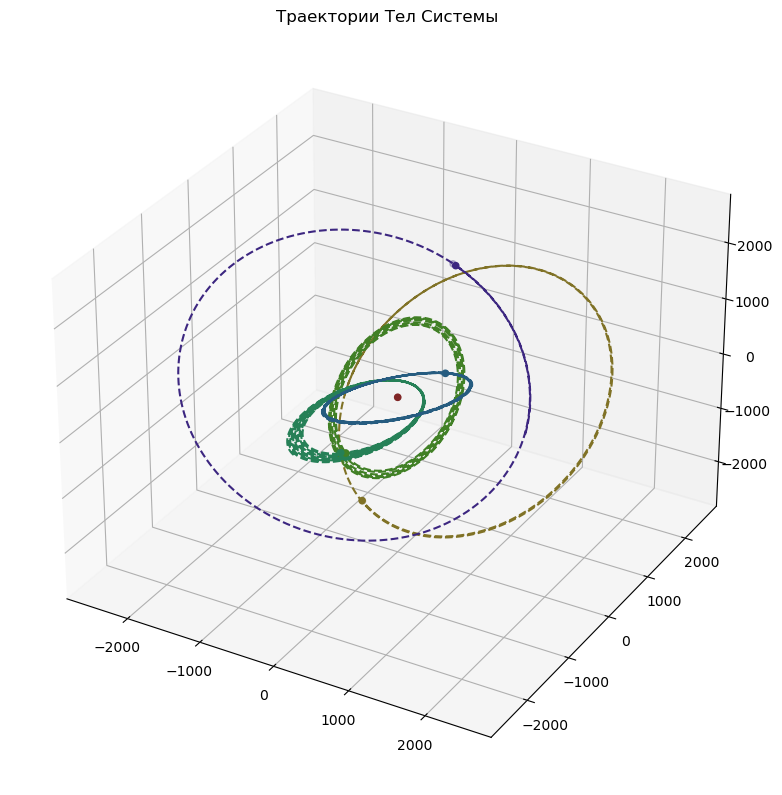

In [25]:
random.seed(32521)

Sys = ObjectSystem()
Sys.Normal_Accuracy()


Sys.Add_Object_parameters([0.,0.,0.],[0.,0.,0.],1.0E+10,1.0)

Sys.Add_Planet_orbit(1.0E+3, 1.0, 0.900)
Sys.Add_Planet_orbit(1.2E+3, 1.0, 0.707)
Sys.Add_Planet_orbit(1.5E+3, 1.0, 0.4)
Sys.Add_Planet_orbit(0.9E+3, 1.0, 0.71)


Sys.IterateTime(1.0E+6)


Sys.Add_Object_parameters([1.7E+3,0.,0.],[0.,0.01,0.02],1.0E+6,1.0)


Sys.IterateTime(1.0E+6)


Sys.draw()

In [26]:
Sys.animate(0, 2.0E+6, 120, 10, 1.0E+5)

Calculating


MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved as Animation.gif


<Figure size 1000x1000 with 0 Axes>

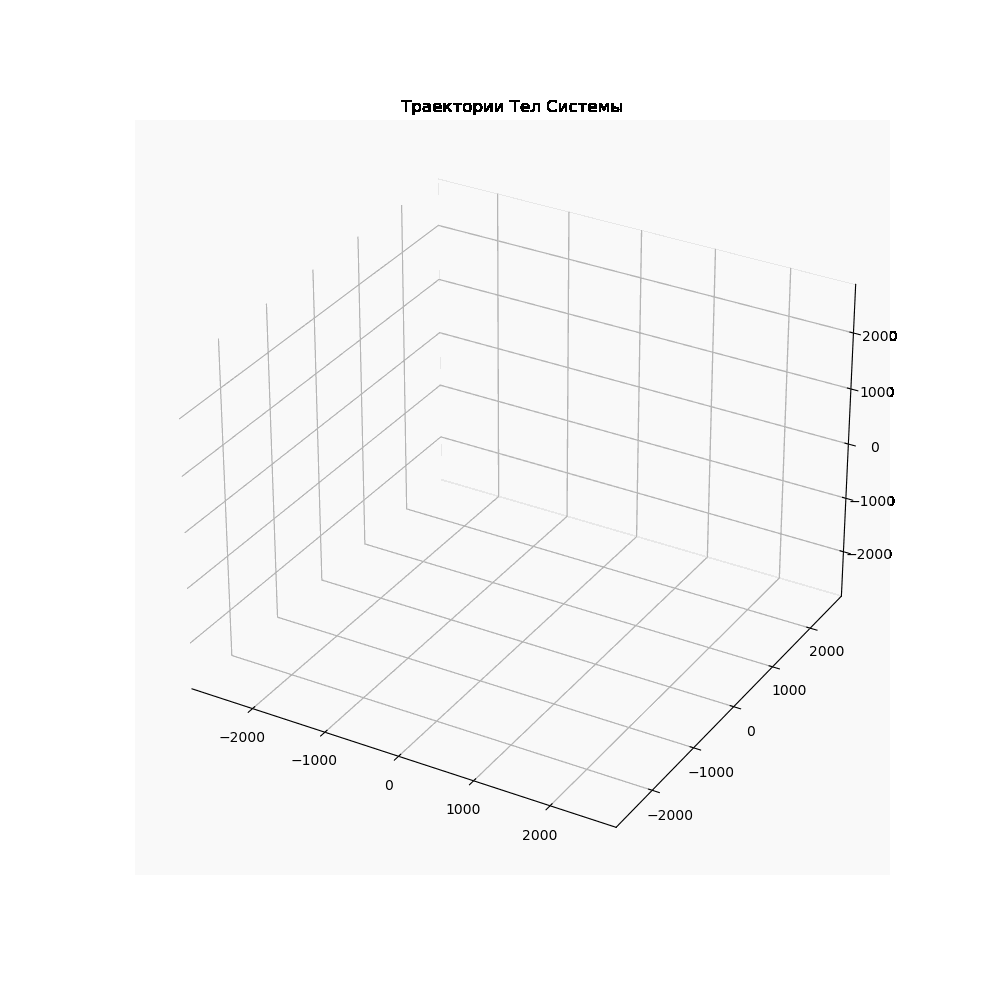

In [27]:
Image(open('Animation.gif','rb').read())